# Insider Threat
----

# Long-range Forecasting and Pattern Discovery given Limited Data

In [1]:
# %load setup_bayes.py
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
# import theano
# import theano.tensor as tt
# import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
# from bqplot import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from beakerx import *
sns.set_context('notebook', font_scale = 1.1)
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 'lines.linewidth': 2.0, 
      'lines.markersize': 8, 'font.family': "serif", 'font.serif': "cm", 'savefig.dpi': 200,
      'text.usetex': False, 'legend.fontsize': 20.0, 'axes.titlesize': 20, "figure.figsize": [20, 12]}
sns.set(rc = rc)
sns.set_style("whitegrid")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gpflow
from gpflowopt.domain import ContinuousParameter
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.acquisition import ExpectedImprovement, MinValueEntropySearch
from gpflowopt.optim import StagedOptimizer, MCOptimizer, SciPyOptimizer  
from gpflowopt.design import LatinHyperCube
import random
random.seed(1234)
from warnings import filterwarnings
filterwarnings("ignore")

## Data Preparation

In [98]:
email_filtered = pd.read_csv("../../data/email_filtered.csv", parse_dates=["date"])

In [99]:
email_filtered.head()      

In [100]:
email_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11920 entries, 0 to 11919
Data columns (total 12 columns):
id             11920 non-null object
date           11920 non-null datetime64[ns]
user           11920 non-null object
pc             11920 non-null object
to             11920 non-null object
cc             6101 non-null object
bcc            593 non-null object
from           11920 non-null object
activity       11920 non-null object
size           11920 non-null int64
attachments    3809 non-null object
content        11920 non-null object
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 1.1+ MB


Let's select one user in particular who is a known insider.


In [101]:
# The insider
df_insider = email_filtered[email_filtered["user"] == "CDE1846"]
df_insider.head()
df_insider.shape

(3165, 12)

In [102]:
emails_per_month = df_insider.resample(rule = "1M", on = "date").sum().reset_index()
emails_per_month["date"] = pd.to_datetime(emails_per_month["date"], format = "%Y-%m-%d")
emails_per_month.columns = ["ds", "y"]
emails_per_month

In [103]:
emails_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
ds    17 non-null datetime64[ns]
y     17 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 352.0 bytes


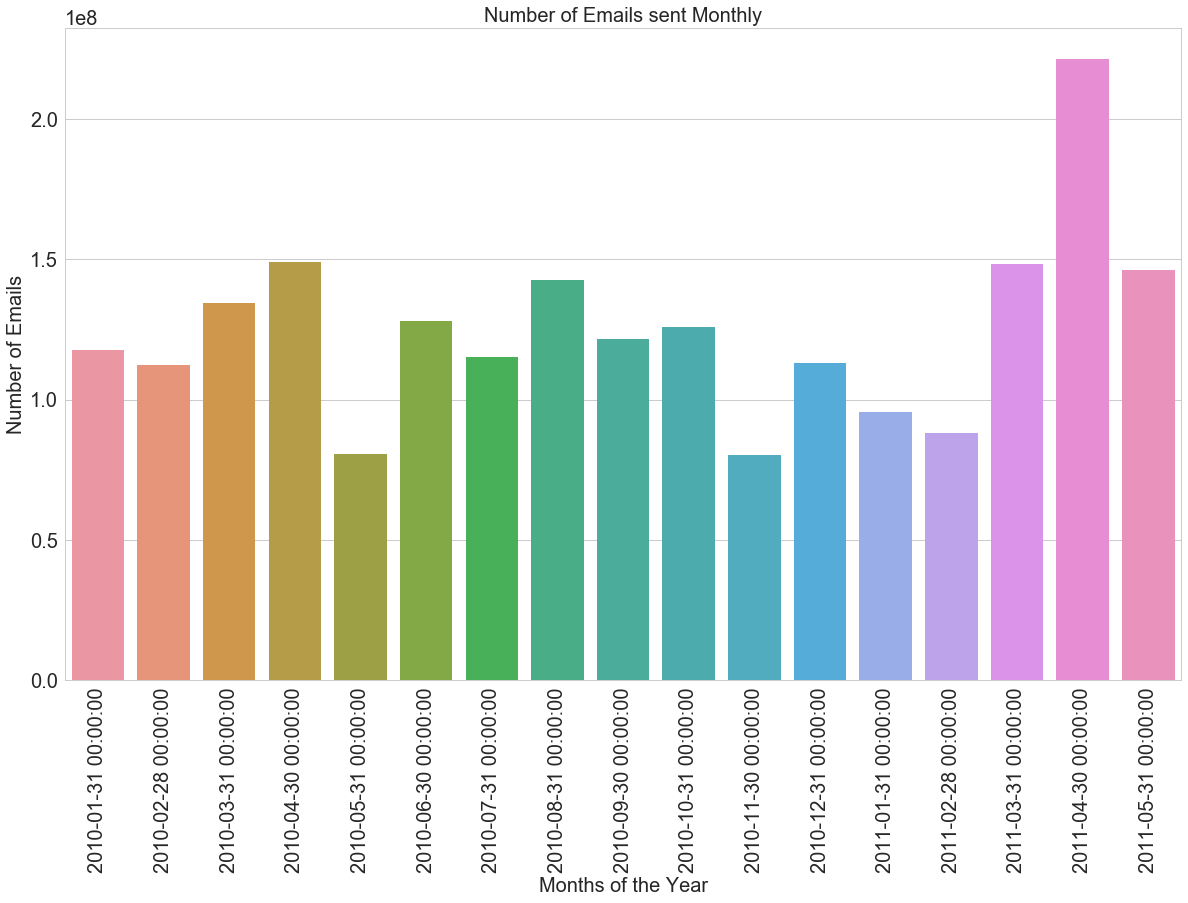

In [104]:
fig, ax = plt.subplots()
sns.barplot(data = emails_per_month, x = "ds", y = "y", ax = ax)
ax.set_xticklabels(labels = emails_per_month["ds"], rotation = 90)
ax.set_xlabel("Months of the Year")
ax.set_ylabel("Number of Emails")
ax.set_title("Number of Emails sent Monthly");

In [105]:
df_insider_non_org = df_insider[~df_insider['to'].str.contains('dtaa.com')]
df_insider_non_org

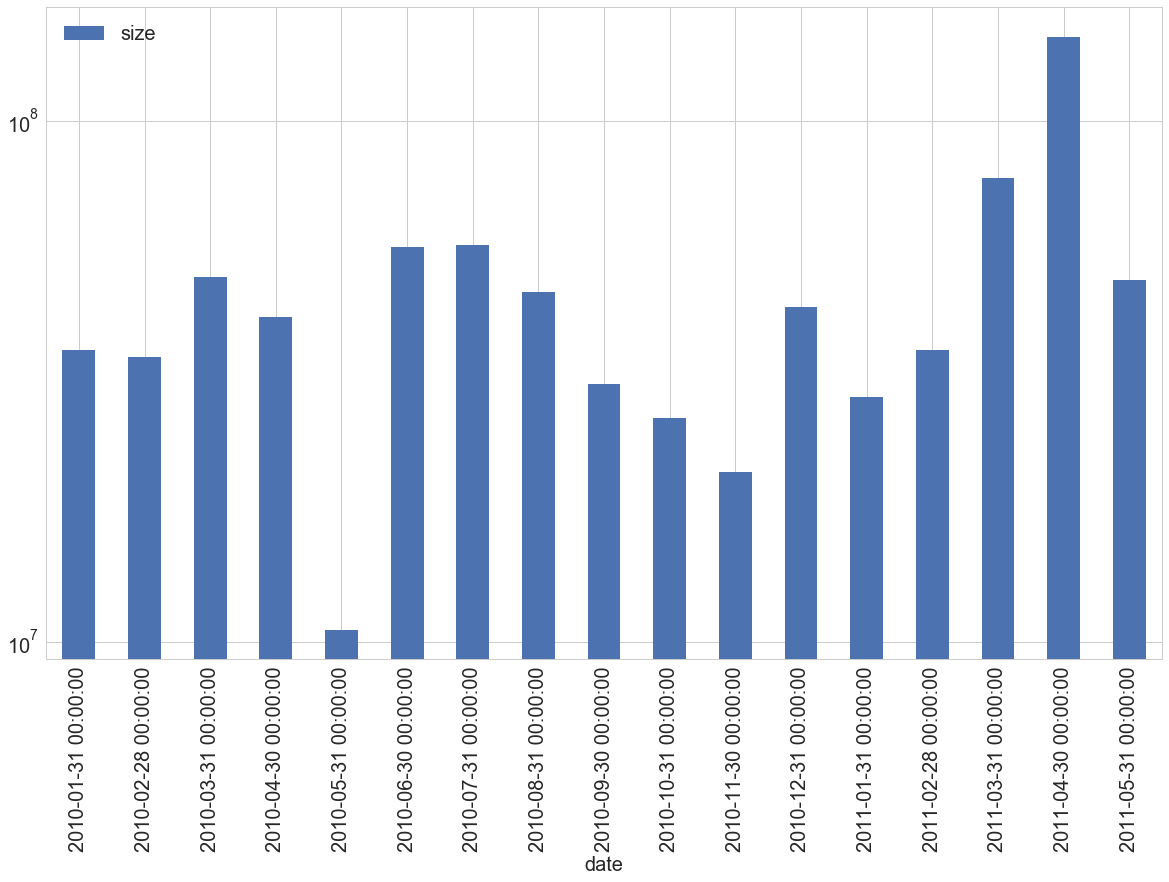

In [106]:
df_insider_non_org.resample(rule = "1M", on = "date").sum().plot(kind = "bar", logy = "size");

Explore Insider Threat Case

In [107]:
# Here, we look at the case where the insider email IP to their home account
# The data is resampled per month and the anomalous behavior is clearly
# visible
df_insider_ewing = df_insider_non_org[df_insider_non_org['to'] == 'Ewing_Carlos@comcast.net']
df = df_insider_ewing.resample('1M', on='date').sum().reset_index()
df.columns = ["ds", "y"]
df.y = df.y/1e8

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
ds    17 non-null datetime64[ns]
y     17 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 352.0 bytes


In [109]:
from datetime import datetime
df["ds"] = df.apply(lambda x: datetime.date(x["ds"]), axis = 1)

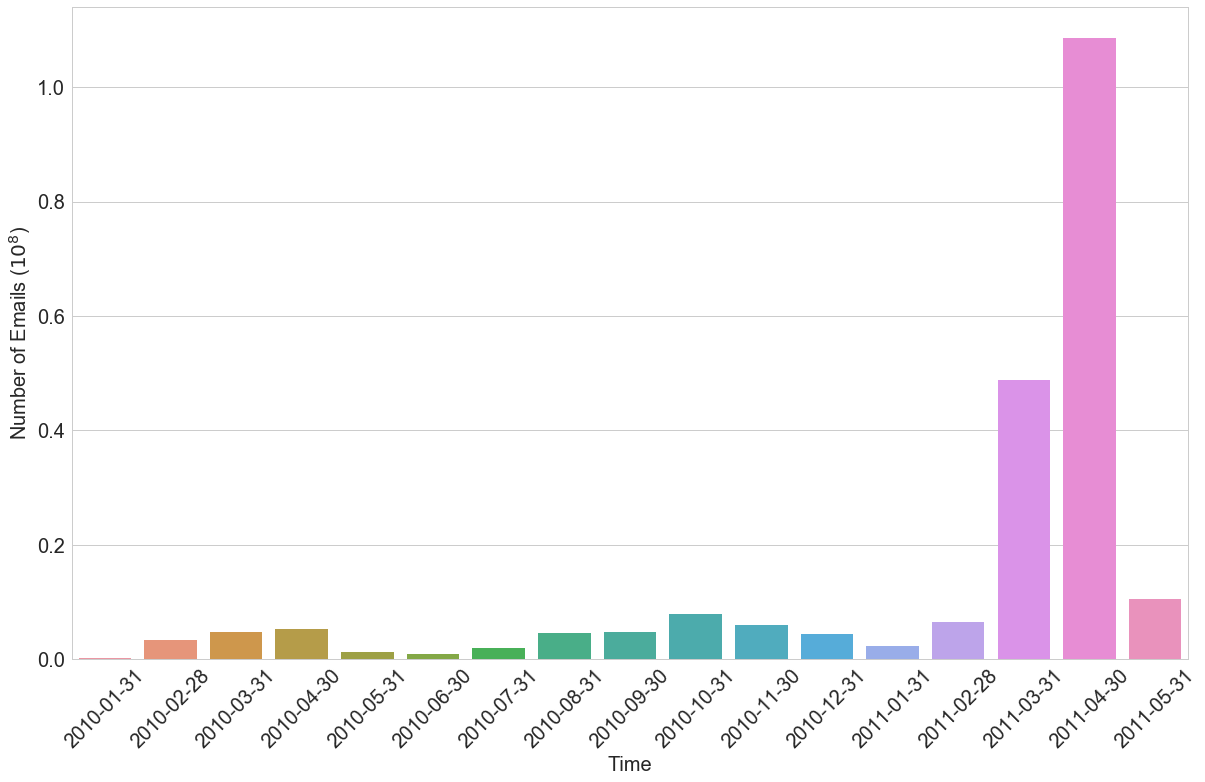

In [110]:
fig, ax = plt.subplots()
sns.barplot(data = df, x = "ds", y = "y")
ax.set_xticklabels(labels = df.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Emails ($10^8$)");
# ax.set_title("Number of Emails sent Monthly");

In [111]:
df.index +=1
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 1 to 17
Data columns (total 2 columns):
ds    17 non-null object
y     17 non-null float64
dtypes: float64(1), object(1)
memory usage: 408.0+ bytes


In [112]:
X_complete = np.array([df.index]).reshape((17, 1)).astype('float64')
X_train = X_complete[0:10, ]
X_test = X_complete[10:18, ]
Y_complete = np.array([df.y]).reshape((17, 1)).astype('float64')
Y_train = Y_complete[0:10, ]
Y_test = Y_complete[10:18, ]
D = Y_train.shape[1];

In [113]:
D

1

In [114]:
Y_train.shape; X_train.shape; Y_test.shape; X_test.shape; X_complete.shape

(10, 1)

(10, 1)

(7, 1)

(7, 1)

(17, 1)

In [115]:
Y_train; X_train; Y_test; X_test; X_complete

array([[ 0.00181588],
       [ 0.03250489],
       [ 0.04749784],
       [ 0.05229758],
       [ 0.01234118],
       [ 0.00946767],
       [ 0.0191637 ],
       [ 0.04527464],
       [ 0.047766  ],
       [ 0.07954557]])

array([[  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.]])

array([[ 0.05903088],
       [ 0.04442788],
       [ 0.02258068],
       [ 0.06430011],
       [ 0.48803904],
       [ 1.08623858],
       [ 0.10496137]])

array([[ 11.],
       [ 12.],
       [ 13.],
       [ 14.],
       [ 15.],
       [ 16.],
       [ 17.]])

array([[  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.],
       [ 11.],
       [ 12.],
       [ 13.],
       [ 14.],
       [ 15.],
       [ 16.],
       [ 17.]])

In [116]:
np.sort(Y_complete.flatten())

array([ 0.00181588,  0.00946767,  0.01234118,  0.0191637 ,  0.02258068,
        0.03250489,  0.04442788,  0.04527464,  0.04749784,  0.047766  ,
        0.05229758,  0.05903088,  0.06430011,  0.07954557,  0.10496137,
        0.48803904,  1.08623858])

In [117]:
Y_train.dtype

dtype('float64')

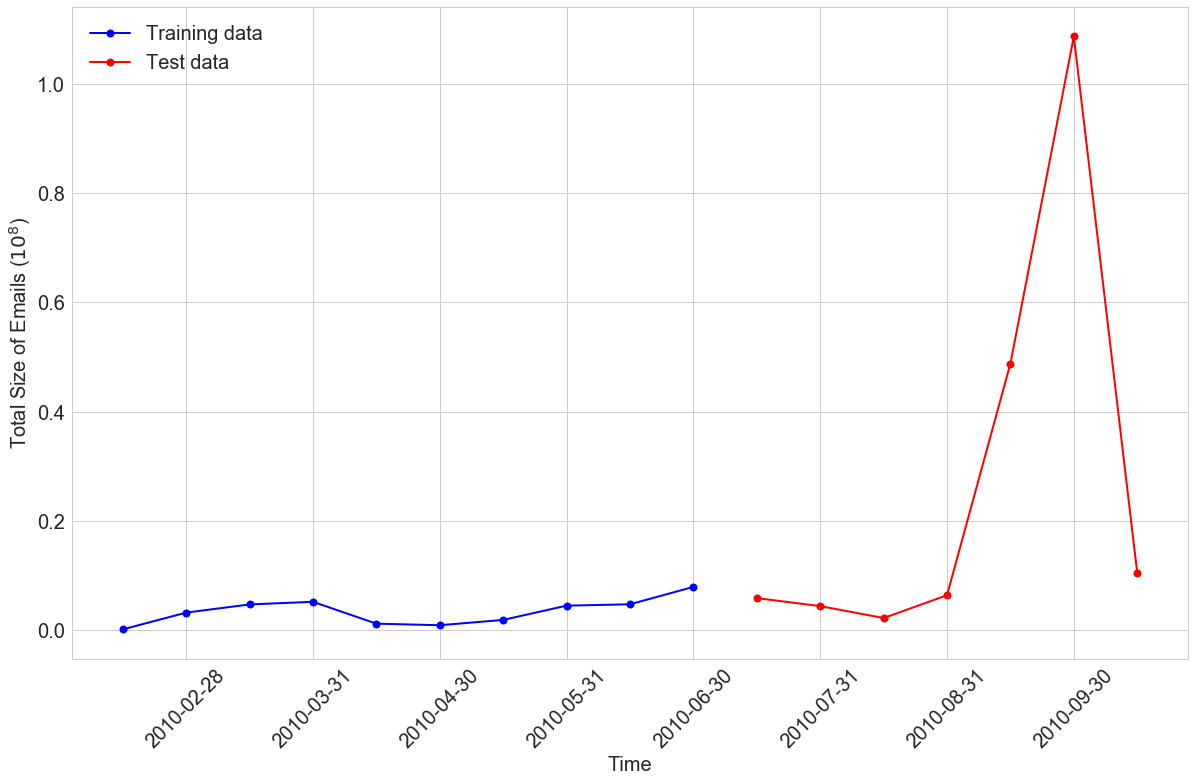

In [118]:
fig, ax = plt.subplots()
ax.plot(X_train.flatten(),Y_train.flatten(), c ='b', marker = "o", label = "Training data")
ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
ax.set_xticklabels(labels = df.ds, rotation = 45)
ax.set_xlabel('Time')
ax.set_ylabel('Total Size of Emails ($10^8$)')
plt.legend(loc = "best");
# fig1 = plt.gcf()
# py.offline.iplot_mpl(fig1);

## Gaussian Process modeling

This study used a Gaussian Process model with a Spectral Mixture (SM) kernel proposed by Wilson (2014). This is because the SM kernel is capable of capturing hidden structure with data without hard cording features in a kernel. Moreover, the SM kernel is capable of performing long-range extrapolation beyond available data.


In [23]:
# Trains a model with a spectral mixture kernel, given an ndarray of 
# 2Q frequencies and lengthscales

Q = 10 # nr of terms in the sum
max_iters = 1000

def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]

    kterms = []
    for i in range(Q):
        rbf = gpflow.kernels.RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = gpflow.transforms.Exp()
        cos = gpflow.kernels.Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)

    k = np.sum(kterms) + gpflow.kernels.Linear(D) + gpflow.kernels.Bias(D)
    m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
    return m

m = create_model(np.ones((2*Q,)))

In [24]:
%%time
m.optimize(maxiter = max_iters)

CPU times: user 8.33 s, sys: 565 ms, total: 8.9 s
Wall time: 7.99 s


      fun: -24.266700642997868
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.31369812e-82,   4.28799301e-05,  -2.00051423e-07,
        -3.65806489e-05,  -9.00480249e-06,  -6.52383047e-05,
        -2.00051423e-07,  -3.65806489e-05,  -9.00480249e-06,
        -6.52383047e-05,  -2.00051423e-07,  -3.65806489e-05,
        -9.00480249e-06,  -6.52383047e-05,  -2.00051423e-07,
        -3.65806489e-05,  -9.00480249e-06,  -6.52383047e-05,
        -2.00051423e-07,  -3.65806489e-05,  -9.00480249e-06,
        -6.52383047e-05,  -2.00051423e-07,  -3.65806489e-05,
        -9.00480249e-06,  -6.52383047e-05,  -2.00051423e-07,
        -3.65806489e-05,  -9.00480249e-06,  -6.52383047e-05,
        -2.00051423e-07,  -3.65806489e-05,  -9.00480249e-06,
        -6.52383047e-05,  -2.00051423e-07,  -3.65806489e-05,
        -9.00480249e-06,  -6.52383047e-05,  -2.00051423e-07,
        -3.65806489e-05,  -9.00480249e-06,  -6.52383047e-05,
        -2.12920633e-27])
  message: b'CONVERG

In [87]:
def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticklabels(labels = df.ds, rotation = 45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Total Size of Emails ($10^8$)');
    ax.plot(X_train.flatten(),Y_train.flatten(), c='b', marker = "o", label = 'Training data')
    ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g', label = "Predicted mean function")
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1, label = "95% Predicted credible interval")
    plt.legend(loc = "best")
    plt.tight_layout()

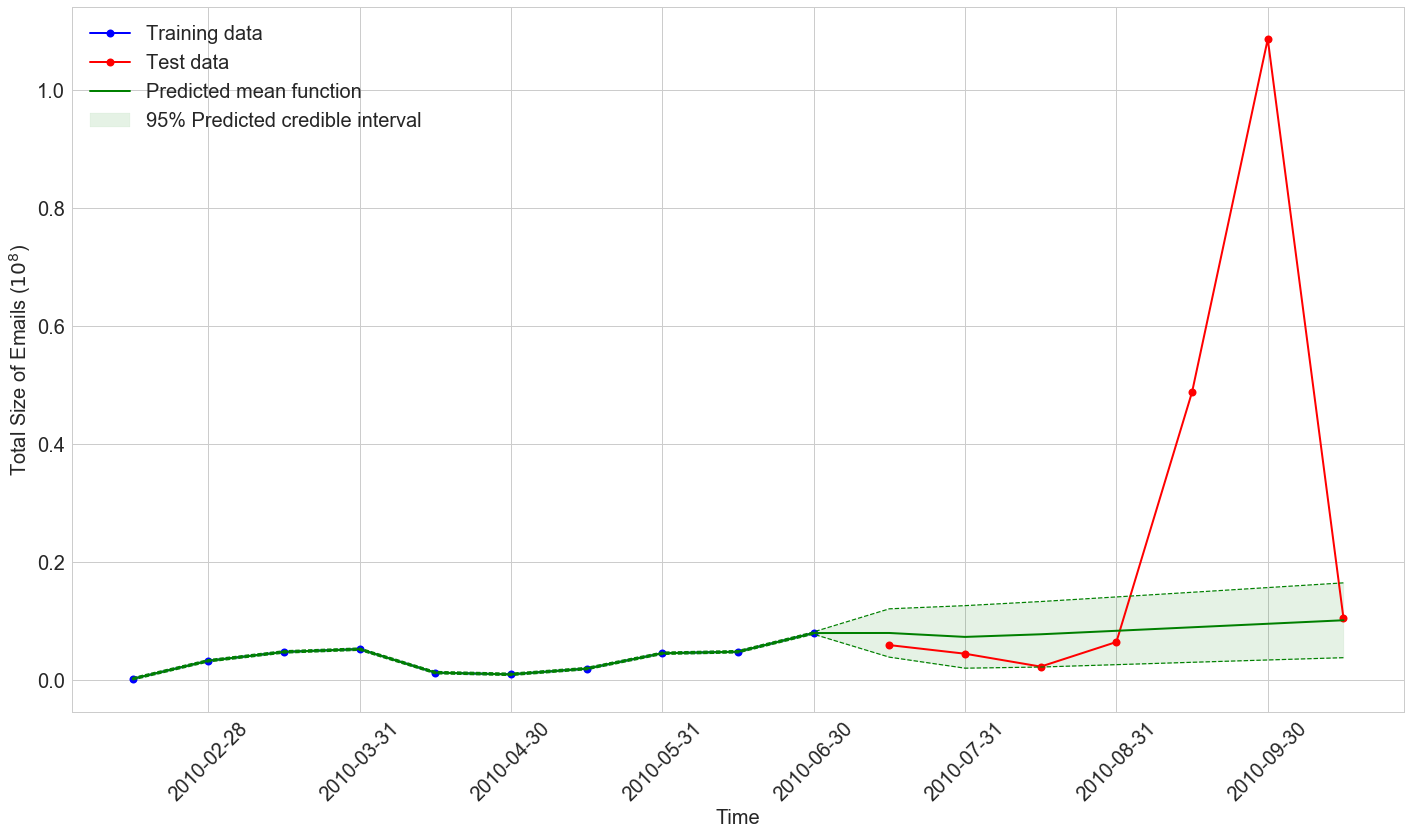

In [119]:
plotprediction(m);

## Perform hyperparameter tuning using Bayesian Optimization

Let's use Bayesian Optimization to find the optimal model parameters of the GP model and then use then to estimate the model and prediction.

In [73]:
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

Name,Type,Values
freq0,Continuous,[ 0. 5.]
freq1,Continuous,[ 0. 5.]
freq2,Continuous,[ 0. 5.]
freq3,Continuous,[ 0. 5.]
freq4,Continuous,[ 0. 5.]
freq5,Continuous,[ 0. 5.]
freq6,Continuous,[ 0. 5.]
freq7,Continuous,[ 0. 5.]
freq8,Continuous,[ 0. 5.]
freq9,Continuous,[ 0. 5.]


In [74]:
%%time
design = LatinHyperCube(6, domain)
X = design.generate()

CPU times: user 1min 29s, sys: 17.5 s, total: 1min 47s
Wall time: 1min 47s


In [75]:
%%time
Y = objectivefx(X)

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:109: RuntimeWarning: overflow encountered in exp
  return np.exp(x) + self._lower


CPU times: user 4min 18s, sys: 4.94 s, total: 4min 23s
Wall time: 4min 19s


In [76]:
%%time
k_surrogate = gpflow.kernels.Matern52(input_dim = domain.size, ARD = False)

CPU times: user 165 µs, sys: 1 µs, total: 166 µs
Wall time: 172 µs


In [77]:
%%time
model_surrogate = gpflow.gpr.GPR(X, Y, kern = k_surrogate)

CPU times: user 597 µs, sys: 343 µs, total: 940 µs
Wall time: 697 µs


In [78]:
%%time
acq_fn = ExpectedImprovement(model_surrogate)
# acq_fn = MinValueEntropySearch(model_surrogate, domain = domain)

CPU times: user 1min 26s, sys: 1.34 s, total: 1min 27s
Wall time: 1min 27s


In [79]:
%%time
acq_optimizer = StagedOptimizer([MCOptimizer(domain, nsamples = 5000), 
                                SciPyOptimizer(domain)])

CPU times: user 855 µs, sys: 311 µs, total: 1.17 ms
Wall time: 874 µs


In [80]:
%%time
optimizer = BayesianOptimizer(domain = domain, 
                              acquisition = acq_fn, 
                              optimizer = acq_optimizer)

CPU times: user 20.6 s, sys: 393 ms, total: 20.9 s
Wall time: 20.9 s


In [81]:
%%time
with optimizer.silent():
    result = optimizer.optimize(objectivefx = objectivefx, n_iter = 30)

CPU times: user 2h 25min 16s, sys: 15min 8s, total: 2h 40min 25s
Wall time: 3h 35min 37s


In [82]:
print(result)

     fun: array([-35.09887124])
 message: 'OK'
    nfev: 30
 success: True
       x: array([[   3.11503674,    0.65509272,    4.2598207 ,    4.72790621,
           3.39409349,    1.54093206,    2.69931246,    0.39148675,
           2.96457509,    3.95119593,  185.28932601,  181.34164004,
         202.42292213,  237.11472621,   57.95781102,   67.90487237,
         225.6737833 ,  186.75337044,  125.99410779,   31.57292726]])


In [83]:
%%time
m_opt = create_model(result.x[0,:])
m_opt.optimize()

CPU times: user 2min 2s, sys: 58.9 s, total: 3min 1s
Wall time: 3min 14s


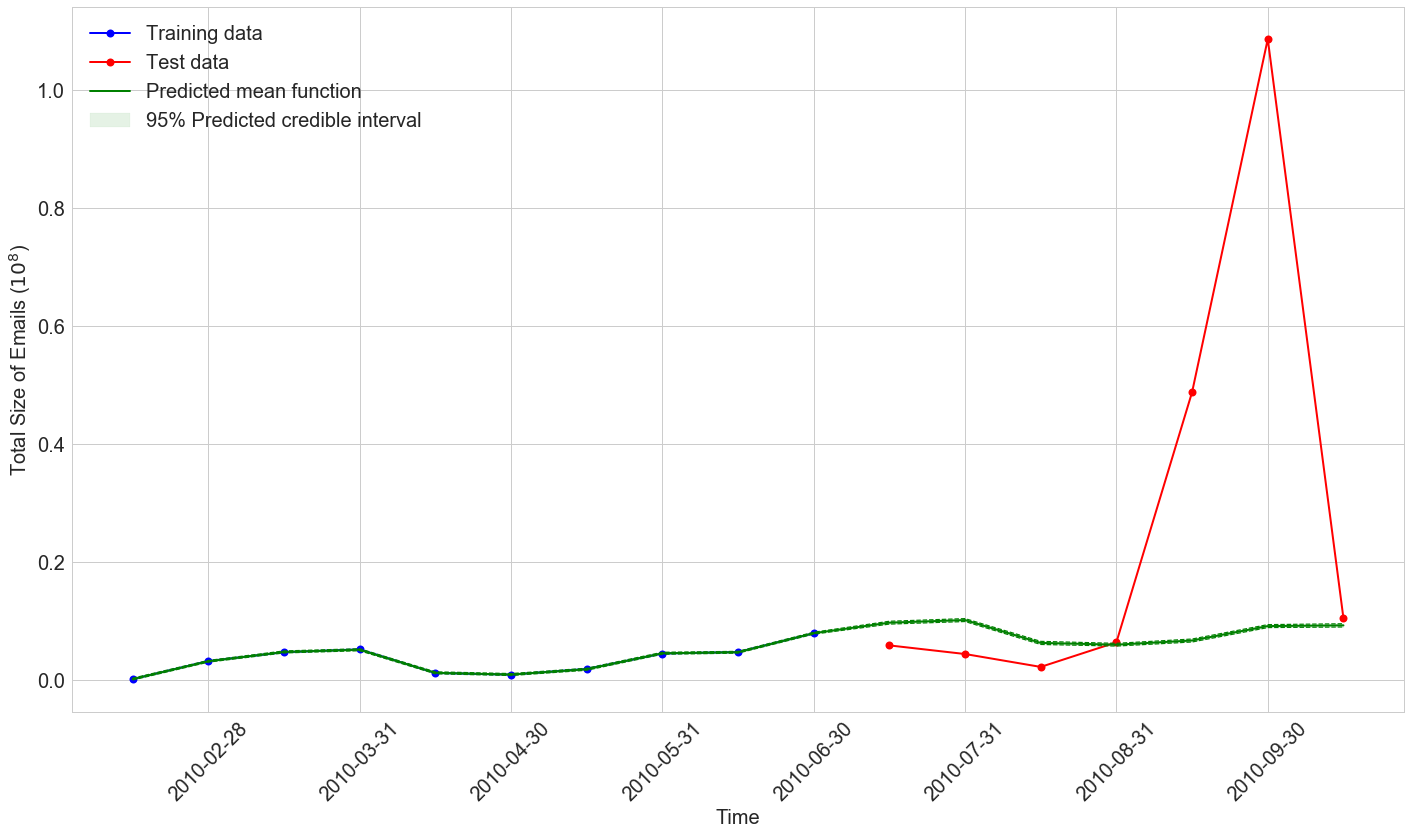

In [120]:
plotprediction(m_opt)

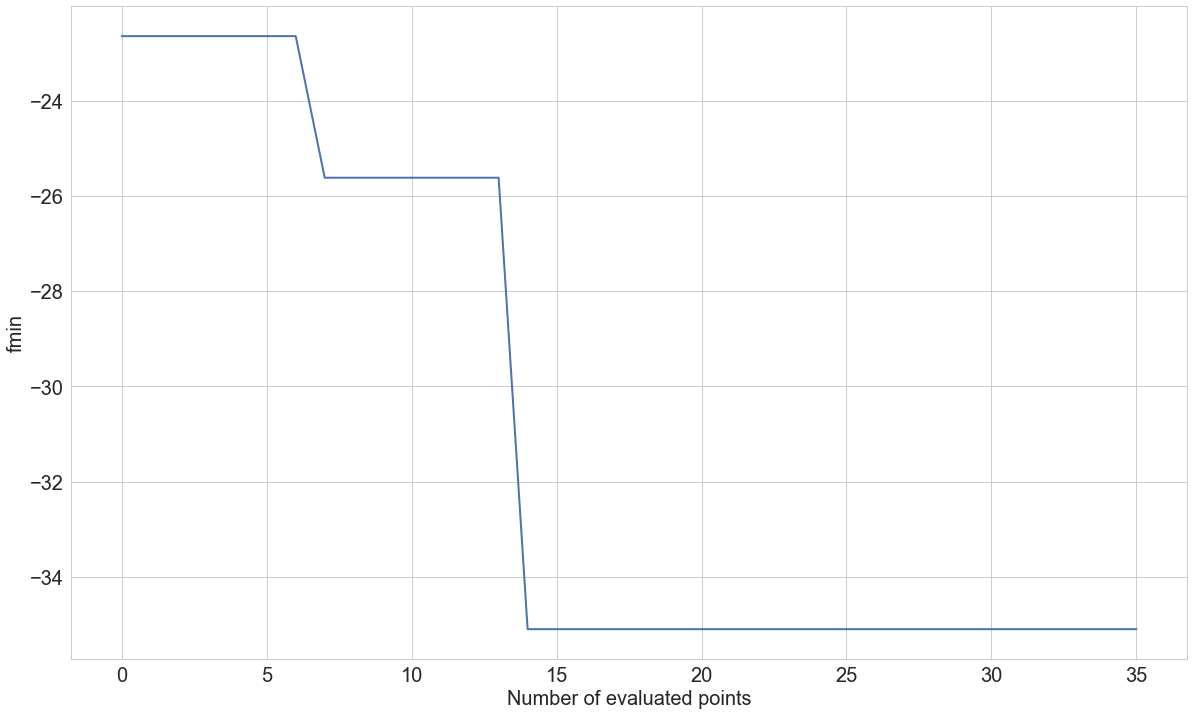

In [85]:
## Inspect the evolution
f, axes = plt.subplots()
f = acq_fn.data[1][:,0]
axes.plot(np.arange(0, acq_fn.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points');

In [86]:
# # save the model and results to the files 'model.pkl' model_optimized.pkl'
# # and 'results.pkl' for later use
# with open('results-saved/emails/model.pkl', 'wb') as mdl:
#     pickle.dump(m, mdl, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('results-saved/emails/model_optimized.pkl', 'wb') as mdl_opt:
#     pickle.dump(m_opt, mdl_opt, protocol = pickle.HIGHEST_PROTOCOL)    
    
# with open('results-saved/emails/result_optimized.pkl', 'wb') as res:
#     pickle.dump(result, res, protocol = pickle.HIGHEST_PROTOCOL) 
    
# with open('results-saved/emails/acq_fn.pkl', 'wb') as acq:
#     pickle.dump(acq_fn, acq, protocol = pickle.HIGHEST_PROTOCOL)     

In [70]:
# # load it at some future point
# with open('results-saved/emails/model.pkl', 'rb') as mdl:
#     m = pickle.load(mdl)

# with open('results-saved/emails/model_optimized.pkl', 'rb') as mdl_opt:
#     m_opt = pickle.load(mdl_opt)
    
# with open('results-saved/emails/result_optimized.pkl', 'rb') as res:
#     result = pickle.load(res)   
    
# with open('results-saved/emails/acq_fn.pkl', 'rb') as acq:
#     acq_fn = pickle.load(acq)       

In [121]:
# improve quality of figures for journal paper
%config InlineBackend.figure_format = "retina" 

In [41]:
# print system information/setup
%reload_ext watermark
%watermark -v -m -p numpy,pandas,gpflowopt,gpflow,tensorflow,matplotlib,ipywidgets,beakerx,seaborn -g

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
gpflowopt 0.1.0
gpflow 0.4.0
tensorflow 1.4.1
matplotlib 2.1.1
ipywidgets 7.1.1
beakerx 0.12.1
seaborn 0.8.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ec4acbc8fd100b0026f5bfc545a6efeb4a191b89
